<a href="https://colab.research.google.com/github/farahh1/in202.github.io/blob/master/Drive_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
import pandas as pd
import numpy as np
import csv
import random

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

!pip install catboost -q  
from catboost import CatBoostClassifier



     |████████████████████████████████| 69.2MB 55kB/s 


In [ ]:
df= pd.read_csv('/content/german_credit_data (1).csv',sep=';')

# **Exploring the DATA + Process**

> [Bloc en retrait](https://)



In [ ]:
df.head()
#Age (numeric)
#Sex (text: male, female)
#Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
#Housing (text: own, rent, or free)
#Saving accounts (text - little, moderate, quite rich, rich)
#Checking account (text - little, moderate, quite rich, rich)
#Credit amount (numeric, in DM)
#Duration (numeric, in month)
#Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
#Risk (Value target - Good or Bad Risk)


,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
df.columns

Index(['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')



```
# Ce texte est au format code
```

### **Label Encoder**

In [ ]:
#Label Encoder
LE=LabelEncoder()
feature_to_encode1=['Sex','Housing','Purpose','Risk']


In [ ]:
for feature in feature_to_encode1 :
   df[feature]= LE.fit_transform(df[feature])
Saving_acc={'little':1,'moderate': 2, 'quite rich': 3, 'rich' : 4}
df['Saving accounts']=df['Saving accounts'].map(Saving_acc)
Checking_acc={'little':1,'moderate': 2, 'rich' : 3}
df['Checking account']=df['Checking account'].map(Checking_acc)

In [ ]:
df['Duration']=df['Duration'].apply(int)

**Convert DM to Euro**

In [ ]:
df["Credit amount"] = 0.51 * df["Credit amount"]

In [ ]:
df.head()


,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,1,2,1,NaN,1.0,596.19,6,5,1
1,1,22,0,2,1,1.0,2.0,3035.01,48,5,0
2,2,49,1,1,1,1.0,NaN,1068.96,12,3,1
3,3,45,1,2,0,1.0,1.0,4019.82,42,4,1
4,4,53,1,2,0,1.0,1.0,2483.70,24,1,0


In [ ]:
print(df['Risk'].isin([0]).sum())
print(np.min(df['Age']))

300
19


**Adapting Train Data on Real Data**

In [ ]:
Saving_acc={1:0,2: 0, 3: 1, 4 : 1}
df['Saving accounts']=df['Saving accounts'].map(Saving_acc)
Checking_acc={1:0,2: 1, 3 : 1}
df['Checking account']=df['Checking account'].map(Checking_acc)

In [ ]:
df.head()

**Specifying Target and Features**

In [ ]:
to_drop = ['ID','Risk']
features = [x for x in df.columns if x not in to_drop]
X = df[features]
y = df['Risk']
data_dmatrix = xgb.DMatrix(data=X,label=y)


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=27,stratify=y,test_size=0.2)

# **Modeling: Xgboost**

In [ ]:
xg_cls = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xg_cls.fit(X_train, y_train,
        eval_set=[(X_test,y_test)] ,eval_metric='auc',
        verbose = 100,early_stopping_rounds=20)
y_pred= xg_cls.predict(X_test)

[0]	validation_0-auc:0.711667
Will train until validation_0-auc hasn't improved in 20 rounds.
Stopping. Best iteration:
[51]	validation_0-auc:0.780238



In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.514782


In [ ]:
((y_test==y_pred).sum()/y_test.shape[0])*100

73.5

In [ ]:
y_pred = xg_cls.predict(X_test)
submission = pd.DataFrame()
#submission['unique_id'] = test['ID']
submission['Risk'] = y_pred
submission.to_csv('results_xgb.csv',index=False)

# **k-fold Cross Validation using XGBoost**

---



---



In [ ]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

## **Cross Validation Results**

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.492822,0.000634,0.492969,0.000319
1,0.486291,0.001186,0.486718,0.000411
2,0.480339,0.001632,0.480969,0.000661
3,0.474386,0.002907,0.475203,0.001022
4,0.469888,0.003440,0.470877,0.001155


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.427365
Name: test-rmse-mean, dtype: float64


# **Visualize Boosting Trees and Feature Importance**

In [ ]:
xg_cls = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

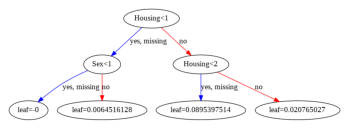

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_cls,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

### **Examine the importance of each feature**




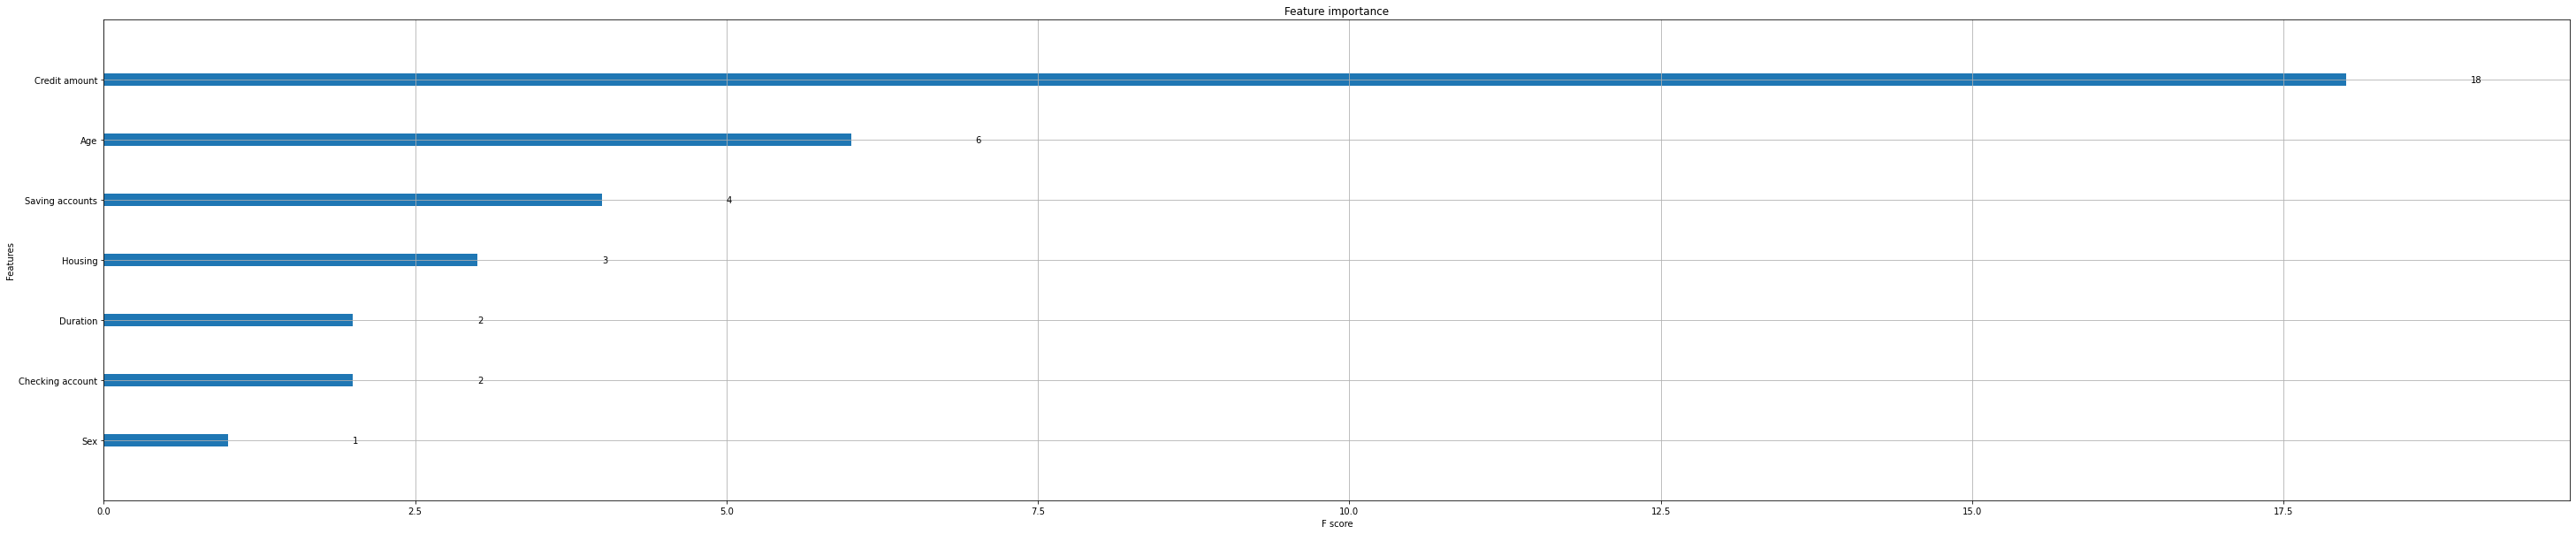

In [ ]:
xgb.plot_importance(xg_cls)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# **Modeling: LightGBM**

In [ ]:
X_train , X_test , y_train , y_test  = train_test_split(X,y,random_state=42 , stratify=y,test_size=0.2)

In [ ]:
LGBMC = LGBMClassifier(n_estimators=1000)
LGBMC.fit(X_train, y_train,
        eval_set=[(X_test,y_test)] ,
        verbose = 100,early_stopping_rounds=100)

Baseline_predictions_lgbm = LGBMC.predict(X_test)
submission = pd.DataFrame()
submission['Risk'] = Baseline_predictions_lgbm

submission.to_csv('results_lgbm.csv',index=False)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.59564
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.520323


In [ ]:
((y_test==Baseline_predictions_lgbm).sum()/y_test.shape[0])*100

76.0

# **Modeling: Catboost**

In [ ]:
X_train , X_test , y_train , y_test  = train_test_split(X,y,random_state=42 ,stratify=y,test_size=0.2)

In [ ]:
CatbC = CatBoostClassifier()

CatbC.fit(X_train, y_train,
        eval_set=[(X_test,y_test)] ,
        verbose = 100,early_stopping_rounds=100)

Baseline_predictions_Catb = CatbC.predict(X_test)
submission = pd.DataFrame()
submission['Risk'] = Baseline_predictions_Catb

submission.to_csv('results_catboost.csv',index=False)

Learning rate set to 0.02999
0:	learn: 0.6808134	test: 0.6837040	best: 0.6837040 (0)	total: 49.6ms	remaining: 49.5s
100:	learn: 0.4134857	test: 0.5182519	best: 0.5181007 (99)	total: 186ms	remaining: 1.66s
200:	learn: 0.3331990	test: 0.5190115	best: 0.5175886 (141)	total: 312ms	remaining: 1.24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5175885673
bestIteration = 141

Shrink model to first 142 iterations.


In [ ]:
((y_test==Baseline_predictions_Catb).sum()/y_test.shape[0])*100

74.5



```
# Ce texte est au format code
```

# **Testing on Real Data**

Beginning with corresponding every feature in the obtained dataset with a feature from the real data that we've got.

### **Reading Data Files**

In [ ]:
df_tierscomptes = pd.read_csv('/content/TiersComptesLocal.csv',sep=';', encoding='latin-1')
df_tierscomptes.head()

,TCL_CodTiers,TCL_CodCompte
0,0x00001AC3E80F561E67CFA8268B743E63,0xB4F5D0FFDC4A6D71B03229260D95E43D
1,0x0002F90B5A0862682F6C79FC41FE7F6D,0x654E455E8B3FBFBD65B2B93761410469
2,0x0005DB92FD995E9ECBBEAA8D1199B182,0x3FDC79FB2618DB9C77C9EB263389A8D8
3,0x00070DABCF611E517278B5D72E2DED67,0x236716BD0EBED6F6661F0804904CA3F3
4,0x00073BE43B1D287915E113529660A51B,0x9859DBCC27B1C030B3A1C790E73A9558


In [ ]:
df_gentiers=pd.read_csv('/content/GénériqueTiers.csv', sep=';',encoding='latin-1')
df_gentiers.head()

,GTI_CodTiers,Age,Sexe,profession,DepartementResidence
0,0x00001AC3E80F561E67CFA8268B743E63,60,Masculin,NON CONNU,10
1,0x0002F90B5A0862682F6C79FC41FE7F6D,70,Masculin,NON CONNU,44
2,0x0005DB92FD995E9ECBBEAA8D1199B182,80,Masculin,NON CONNU,78
3,0x00070DABCF611E517278B5D72E2DED67,90,Masculin,NON CONNU,68
4,0x00073BE43B1D287915E113529660A51B,40,FEMININ,NON CONNU,75


In [ ]:
df_gencomptes_sav=pd.read_csv('/content/GeneriquesComptes.csv', sep=';',encoding='latin-1')
df_gencomptes_sav.head()

,GCO_CodCompte,Saving accounts
0,0x0000A5854D0302D88E898A449B8DA620,0
1,0x000281404B19A7510C2F18EA349A5E23,0
2,0x0006464681FF3A59E441F9FC1116CE76,0
3,0x0007B3B66E723F08C5A5870777AC52B0,0
4,0x0008A4906452181F3D1AE7A5F5568CF3,0


In [ ]:
df_gencomptes2_check = pd.read_csv('/content/GenComptes2.csv',sep=';', encoding='latin-1')
df_gencomptes2_check.head()

,GCO_CodCompte,Checking account
0,0x0000A5854D0302D88E898A449B8DA620,0
1,0x00015BDD083C14ADB87509DDED6684DE,0
2,0x000281404B19A7510C2F18EA349A5E23,0
3,0x0006464681FF3A59E441F9FC1116CE76,0
4,0x0007B3B66E723F08C5A5870777AC52B0,0


In [ ]:
df_montants_euro = pd.read_csv('/content/Montants.csv',sep=';', encoding='latin-1')
df_montants_euro.head()

,PGH_CodCompte,PGH_MntSoldeEuro,Unnamed: 2,Unnamed: 3
0,0x00015BDD083C14ADB87509DDED6684DE,0.00,NaN,NaN
1,0x0006464681FF3A59E441F9FC1116CE76,45.15,NaN,NaN
2,0x0007B3B66E723F08C5A5870777AC52B0,0.00,NaN,NaN
3,0x0009FDAF58C86E4BCCF78647FC41F89D,233053.11,NaN,NaN
4,0x000AC7EA5ADEE64ACDE3792D4B15BCF2,17191.47,NaN,NaN


### **Cleaning Data**

In [ ]:
tierscomptes=df_tierscomptes[['TCL_CodCompte','TCL_CodTiers']].values
gentiers=df_gentiers[['GTI_CodTiers','Age','Sexe','profession','DepartementResidence']].values


In [ ]:
L_codcompte=[0]*len(gentiers)
print(len(gentiers))
len(L_codcompte)

54019


54019

In [ ]:
for i in range(len(gentiers)) :
    for j in range(len(tierscomptes)):
         if gentiers[i,0]==tierscomptes[j,1] : 
           L_codcompte[i]=tierscomptes[j,0] 
           break
len(L_codcompte)    

54019

In [ ]:
new_table = np.c_[gentiers,L_codcompte]
new_table

array([['0x00001AC3E80F561E67CFA8268B743E63', 60, 'Masculin',
        'NON CONNU', '10', '0xB4F5D0FFDC4A6D71B03229260D95E43D'],
       ['0x0002F90B5A0862682F6C79FC41FE7F6D', 70, 'Masculin',
        'NON CONNU', '44', '0x654E455E8B3FBFBD65B2B93761410469'],
       ['0x0005DB92FD995E9ECBBEAA8D1199B182', 80, 'Masculin',
        'NON CONNU', '78', '0x3FDC79FB2618DB9C77C9EB263389A8D8'],
       ...,
       ['0xFFFD2F9166A542B1E2784BF4C807E464', 40, 'Masculin',
        'NON CONNU', '0', '0'],
       ['0xFFFE503A6890FA09CCDE727FFEFEB53E', 40, 'Masculin',
        "Chef d'entreprise", '75', '0x61175C904B055742FFAE316487F0656F'],
       ['0xFFFEF736074E242DBC54A7CF43D3A15D', 50, 'Masculin',
        'NON CONNU', '11', '0xBD748BC3786870540A7CE0D2865CDAFC']],
      dtype=object)

In [ ]:
i=0
while(i<len(new_table)) :
         if new_table[i,5]=='0' :
           new_table = np.delete(new_table, (i), axis=0) 
         else : 
              i=i+1

**Adding Credit Amount**

In [ ]:
montants=df_montants_euro[['PGH_CodCompte','PGH_MntSoldeEuro']].values
print(montants.shape)


(65339, 2)


In [ ]:
#deleting redondants
i=0
while(i<len(montants)-1) :
  if montants[i,0]==montants[i+1,0] : 
    if montants[i,1]<montants[i+1,1] : 
      montants=np.delete(montants, (i), axis=0)
    else: montants=np.delete(montants, (i+1), axis=0)
  else: i=i+1


In [ ]:
print(montants.shape)

(32116, 2)


In [ ]:
L_montants=[0.0001]*len(new_table)

In [ ]:
for i in range(len(new_table)) :
    for j in range(len(montants)):
         if new_table[i,5]==montants[j,0] : 
           L_montants[i]=montants[j,1] 
           break

In [ ]:
new_table = np.c_[new_table,L_montants]

In [ ]:
new_table.shape

(49295, 7)

In [ ]:
i=0
while(i<len(new_table)) :
         if new_table[i,6]==0.0001 :
           new_table = np.delete(new_table, (i), axis=0) 
         else : 
              i=i+1


**Adding Savings and Checking Accounts**

In [ ]:
new_table

array([['0x00001AC3E80F561E67CFA8268B743E63', 60, 'Masculin', ..., '10',
        '0xB4F5D0FFDC4A6D71B03229260D95E43D', 19111.81],
       ['0x00073BE43B1D287915E113529660A51B', 40, 'FEMININ', ..., '75',
        '0x9859DBCC27B1C030B3A1C790E73A9558', -463.65],
       ['0x0008F2389015100E1038F5B0A67F789B', 50, 'FEMININ', ..., '92',
        '0xC6E3DBEF4E09F536AB572582BF2B0F6F', 59.8],
       ...,
       ['0xFFFBFEC47176DCB4CE3696EFDF9FA1D6', 80, 'Masculin', ..., '75',
        '0x76D63FAD1BC19EA3DFCF83564441B58F', 25.0],
       ['0xFFFE503A6890FA09CCDE727FFEFEB53E', 40, 'Masculin', ..., '75',
        '0x61175C904B055742FFAE316487F0656F', 3056.13],
       ['0xFFFEF736074E242DBC54A7CF43D3A15D', 50, 'Masculin', ..., '11',
        '0xBD748BC3786870540A7CE0D2865CDAFC', 0.0]], dtype=object)

In [ ]:
savings=df_gencomptes_sav[['GCO_CodCompte','Saving accounts']].values
checkings=df_gencomptes2_check[['GCO_CodCompte','Checking account']].values

In [ ]:
L_sav=[-1]*len(new_table)
L_check=[-1]*len(new_table)

In [ ]:
print(len(new_table))
print(len(savings))
print(len(checkings))

24191
60660
47455


In [ ]:
for i in range(len(new_table)) :
    for j in range(len(savings)):
         if new_table[i,5]==savings[j,0] : 
           L_sav[i]=savings[j,1] 
           break

In [ ]:
for i in range(len(new_table)) :
    for j in range(len(checkings)):
         if new_table[i,5]==checkings[j,0] : 
           L_check[i]=checkings[j,1] 
           break

In [ ]:
new_table = np.c_[new_table,L_sav,L_check]
new_table.shape

(24191, 9)

In [ ]:
i=0
while(i<len(new_table)) :
         if new_table[i,7]==-1 or new_table[i,8]==-1 :
           new_table = np.delete(new_table, (i), axis=0) 
         else: 
              i=i+1

In [ ]:
new_table.shape

(19661, 9)

# **(19661,9)**

# **Creating new DataFrame with all columns from Real Data**

In [ ]:
realData=[new_table[:,5],new_table[:,1],new_table[:,2], new_table[:,3] ,new_table[:,4],new_table[:,7],new_table[:,8],new_table[:,6]]
realData=np.transpose(realData)
realData
df_realData=pd.DataFrame(realData, columns = ['ID', 'Age','Sex','Job','Housing','Saving accounts','Checking account','Credit amount_Euro'])


In [ ]:
df_realData.sort_values("ID", inplace = True)
df_realData.drop_duplicates(subset ="ID",keep = False, inplace = True)

In [ ]:
df_realData['Age']=df_realData['Age'].apply(int)
df_realData['Saving accounts']=df_realData['Saving accounts'].apply(int)
df_realData['Checking account']=df_realData['Checking account'].apply(int)


In [ ]:
df_realData['Age']=df_realData['Age'].astype(np.int32)
df_realData['Saving accounts']=df_realData['Saving accounts'].astype(np.int32)
df_realData['Checking account']=df_realData['Checking account'].astype(np.int32)

In [ ]:
df_realData.describe()

,Age,Saving accounts,Checking account
count,13644.000000,13644.000000,13644.000000
mean,62.035767,0.011214,0.008575
std,22.149771,0.105303,0.092208
min,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.000000
50%,67.000000,0.000000,0.000000
75%,80.000000,0.000000,0.000000
max,190.000000,1.000000,1.000000


**Preparing Sex, Job and Housing feature**

In [ ]:
Sex_values={'FEMININ':0,'Masculin':1}
df_realData['Sex']=df_realData['Sex'].map(Sex_values)

In [ ]:
Job_values={**dict.fromkeys(['NON CONNU','Sans Profession'],0),**dict.fromkeys(['Fonctionnaire','Employe','Secretaire','Etudiant','Acheteur','Agent','Vendeur'],1) ,
            **dict.fromkeys(['Enseignant','T?nicien''Retraite','Agent bancaire',"Agent d'assurance",'Agent immobilier','Agriculteur','Analyste','Antiquaire',
                             'Architecte','Artiste','Rentier','Assistant','Publicitaire','Pharmacien','Notaire','Photographe',
                             'Professeur','Avocat','Biologiste','Hotelier','Commer?ant','Ceramiste' ,'Commer?„ant','Chercheur','Chimiste','Veterinaire','Chirurgien',
                             'Comptable','Conseiller','Consul','Controleur','Dentiste','Diplomate','Docteur','Economiste','Employ?dministratif','Employ?e banque',
                             'Employ?ULL','Employe administratif','Interpr??te','Informaticien','Infirmi??re','Infirmi?re','Employee','Entrepreneur','Employe de banque',
                             'Medecin','Pilote','Professeur','Psychologue','Publicitaire','Rentier','Repr?ntant',
                             'Traducteur','Repr?ntant','Libraire','Secr?ire','Juriste','Journaliste','Jardinier','Sculpteur','Statisticien','Sportif professionnel'],2),
            **dict.fromkeys(["Chef d'entreprise",'Ingenieur','Gerant','Cadre','Chef de service','Directeur'],3)}
df_realData['Job']=df_realData['Job'].map(Job_values)


In [ ]:
df_realData['Housing'] = df_realData['Housing'].fillna(0)
df_realData['Housing']=df_realData['Housing'].apply(int)
df_realData['Housing']=df_realData['Housing'].astype(np.int32)
L=[]
for x in df_realData['Housing'].values:
  if x in range(0,34): 
    L.append(0)
  elif x in range (33,67): L.append(1)
  else: L.append(2)
dict={'Housing':L}

df_realData['Housing']=pd.DataFrame(dict)  

In [ ]:
df_realData

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount_Euro
18649,0x00015BDD083C14ADB87509DDED6684DE,70,1,0.0,NaN,1,0,0
8693,0x0006464681FF3A59E441F9FC1116CE76,10,0,0.0,2.0,0,0,45.15
18851,0x0007B3B66E723F08C5A5870777AC52B0,50,0,0.0,NaN,0,0,0
8328,0x000C20CA991D8F954439EEEB431607A0,40,1,0.0,2.0,0,0,0
17783,0x000C7E3532D3DB716CCFA2FBF273A05E,90,0,0.0,NaN,0,0,0
...,...,...,...,...,...,...,...,...
6914,0xFFDC714C6F2F6CAA09C53455659AAF9C,10,0,0.0,0.0,0,0,4715.92
15287,0xFFE66C64DF0E6B7D8088C7A100289140,60,1,3.0,NaN,0,0,2425.28
4946,0xFFE8A978D5875405D36AF7B6A683845A,80,1,0.0,2.0,0,0,0
10804,0xFFE96216F2634F3145ABD52E43CB204B,30,0,0.0,2.0,0,0,8827.45


**Preparing Duration feature**

In [ ]:
print('max ',df_realData['Credit amount_Euro'].max())
print('min ',df_realData['Credit amount_Euro'].min())
print('median ',np.median(df_realData['Credit amount_Euro']))
print('25 ',np.percentile(df_realData['Credit amount_Euro'],25))
print('50 ',np.percentile(df_realData['Credit amount_Euro'],50))
print('75 ',np.percentile(df_realData['Credit amount_Euro'],75))

max  8138157.82
min  -2258154.92
median  0.0
25  0.0
50  0.0
75  365.7575


In [ ]:
print('max ',df['Duration'].max())
print('min ',df['Duration'].min())
print('median ',np.median(df['Duration']))
print('25 ',np.percentile(df['Duration'],25))
print('50 ',np.percentile(df['Duration'],50))
print('75 ',np.percentile(df['Duration'],75))


max  72
min  4
median  18.0
25  12.0
50  18.0
75  24.0


In [ ]:
realData1=df_realData.values
len(realData1)

13644

In [ ]:
L_duration=[0]*len(df_realData)
realData1=df_realData.values
for i in range(len(realData1)):
  if realData1[i,7]< np.median(df_realData['Credit amount_Euro']) : 
    L_duration[i]=random.randint(1,np.median(df['Duration']+120))
  elif realData1[i,7]<=np.percentile(df_realData['Credit amount_Euro'],75) and realData1[i,7]>=np.median(df_realData['Credit amount_Euro']):
    L_duration[i]=random.randint(np.median(df['Duration']+120), np.percentile(df['Duration'],75)+120)
  else: L_duration[i]=random.randint(np.percentile(df['Duration'],75)+120,df['Duration'].max()+120)

In [ ]:
df_realData['Duration']=L_duration

In [ ]:
df_realData

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount_Euro,Duration
18649,0x00015BDD083C14ADB87509DDED6684DE,70,1,0.0,NaN,1,0,0,139
8693,0x0006464681FF3A59E441F9FC1116CE76,10,0,0.0,2.0,0,0,45.15,139
18851,0x0007B3B66E723F08C5A5870777AC52B0,50,0,0.0,NaN,0,0,0,142
8328,0x000C20CA991D8F954439EEEB431607A0,40,1,0.0,2.0,0,0,0,138
17783,0x000C7E3532D3DB716CCFA2FBF273A05E,90,0,0.0,NaN,0,0,0,141
...,...,...,...,...,...,...,...,...,...
6914,0xFFDC714C6F2F6CAA09C53455659AAF9C,10,0,0.0,0.0,0,0,4715.92,181
15287,0xFFE66C64DF0E6B7D8088C7A100289140,60,1,3.0,NaN,0,0,2425.28,151
4946,0xFFE8A978D5875405D36AF7B6A683845A,80,1,0.0,2.0,0,0,0,142
10804,0xFFE96216F2634F3145ABD52E43CB204B,30,0,0.0,2.0,0,0,8827.45,146


**Preparing Purpose feature**

In [ ]:
df_purp=df[['Credit amount','Purpose']]
df_purp.sort_values("Purpose", inplace = True)
purp=df_purp.values
print(purp)

[[1.33722e+03 0.00000e+00]
 [2.18280e+03 0.00000e+00]
 [9.16470e+02 0.00000e+00]
 ...
 [1.34079e+03 7.00000e+00]
 [5.77728e+03 7.00000e+00]
 [9.39624e+03 7.00000e+00]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
L0=[]
L1=[]
L2=[]
L3=[]
L4=[]
L5=[]
L6=[]
L7=[]
for i in range(len(purp)):
  if purp[i,1]==0 : L0.append(purp[i,0])
  elif purp[i,1]==1 : L1.append(purp[i,0])
  elif purp[i,1]==2 : L2.append(purp[i,0])
  elif purp[i,1]==3 : L3.append(purp[i,0])
  elif purp[i,1]==4 : L4.append(purp[i,0])
  elif purp[i,1]==5 : L5.append(purp[i,0])
  elif purp[i,1]==6 : L6.append(purp[i,0])
  else: L7.append(purp[i,0])


In [ ]:
L_moy={'L0':np.mean(L0),'L1':np.mean(L1),'L2':np.mean(L2),'L3':np.mean(L3),'L4':np.mean(L4),'L5':np.mean(L5),'L6':np.mean(L6),
       'L7':np.mean(L7)}
sorted(L_moy.items(), key=lambda x:x[1])


[('L2', 763.9799999999999),
 ('L5', 1268.7033214285716),
 ('L6', 1391.3263636363638),
 ('L3', 1468.3937288135592),
 ('L4', 1564.164364640884),
 ('L1', 1921.7783679525223),
 ('L0', 2120.601030927835),
 ('L7', 4186.759999999999)]

In [ ]:
C1=[2,5,6,3]
C2=[4,1,0,7]
L_purpose=[-1]*len(df_realData)
realData1=df_realData.values
for i in range(len(realData1)):
  if realData1[i,7]< np.median(df_realData['Credit amount_Euro']) : 
    L_purpose[i]=random.choice(C1)
  else: L_purpose[i]=random.choice(C2)

In [ ]:
df_realData['Purpose']=L_purpose

Change Features Names so that they match they training set

In [ ]:
df_realData.rename(columns={'Credit amount_Euro': 'Credit amount'},inplace=True)

In [ ]:
df_realData

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
18649,0x00015BDD083C14ADB87509DDED6684DE,70,1,0.0,NaN,1,0,0.00,139,7
8693,0x0006464681FF3A59E441F9FC1116CE76,10,0,0.0,2.0,0,0,45.15,139,1
18851,0x0007B3B66E723F08C5A5870777AC52B0,50,0,0.0,NaN,0,0,0.00,142,1
8328,0x000C20CA991D8F954439EEEB431607A0,40,1,0.0,2.0,0,0,0.00,138,1
17783,0x000C7E3532D3DB716CCFA2FBF273A05E,90,0,0.0,NaN,0,0,0.00,141,1
...,...,...,...,...,...,...,...,...,...,...
6914,0xFFDC714C6F2F6CAA09C53455659AAF9C,10,0,0.0,0.0,0,0,4715.92,181,4
15287,0xFFE66C64DF0E6B7D8088C7A100289140,60,1,3.0,NaN,0,0,2425.28,151,0
4946,0xFFE8A978D5875405D36AF7B6A683845A,80,1,0.0,2.0,0,0,0.00,142,0
10804,0xFFE96216F2634F3145ABD52E43CB204B,30,0,0.0,2.0,0,0,8827.45,146,0


# **Testing on Real Dataset of a French Bank**

In [ ]:
df_realData.columns

Index(['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [ ]:
df.columns

Index(['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [ ]:
df_realData['Credit amount']=df_realData['Credit amount'].astype(float)

In [ ]:
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose']
X_realData = df_realData[features]
#data_dmatrix = xgb.DMatrix(data=X,label=y)

## **Testing on LightGBM Model**

In [ ]:
y_pred_lbgm = LGBMC.predict(X_realData)

In [ ]:
print(y_pred_lbgm)
print(len(y_pred_lbgm))

[1 0 0 ... 0 0 0]
13644


In [ ]:
y_pred_lbgm

array([1, 0, 0, ..., 0, 0, 0])